In [172]:
import os

import numpy as np
import pandas as pd
from typing import Dict, List
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline


# path = "C:\\Users\\jerchen\\PythonDeveloper\\2021 Quant Programming Task\\2021 Quant Programming Task\\mkt_data"
path = "./mkt_data/"
dir_list = os.listdir(path)
all_data = []
for rd in dir_list:
    print('reading ', rd, '...')
    raw_data = pd.read_csv(path + '/' + rd)
    raw_data['ticker'] = str(rd)[:-4]
    all_data.append(raw_data)
print('all data len ', len(all_data))

#
def cln_df(df: pd.DataFrame):
    cols: List[str] = df.columns
    for col in cols:
        if ' ' in col:
            col_name = col.strip()
            df[col_name] = df[col]
            del df[col]
    return df

all_data = [cln_df(data) for data in all_data]

reading  BLDE.csv ...
reading  TECH.csv ...
reading  SMTC.csv ...
reading  AMZN.csv ...
reading  SHOO.csv ...
reading  PRTS.csv ...
reading  CAL.csv ...
reading  KXIN.csv ...
reading  TTGT.csv ...
reading  XOS.csv ...
all data len  10


In [173]:
def datetime_from_millis(millisec):
    return pd.Timestamp.fromtimestamp(millisec/1000)
def convert_timestamp(df: pd.DataFrame):
    df['time'] = [datetime_from_millis(x) for x in df['timestamp']]
    return df
all_data = [convert_timestamp(data) for data in all_data]

In [159]:
# all_data[0][['timestamp','time']].head()

In [160]:
# from datetime import timedelta
# import time
# from pytz import timezone

# def datetime_from_millis(millisec):
#     return pd.to_datetime(datetime.fromtimestamp(millisec/1000, timezone("US/Eastern")).isoformat('T', 'milliseconds'))
# def convert_timestamp(df: pd.DataFrame):
#     df['time'] = [datetime_from_millis(x) for x in df['timestamp']]
#     return df
# all_data = [convert_timestamp(data) for data in all_data]

Plotting

In [182]:
def get_target_cols(df:pd.DataFrame):
    df['non_cum_vol'] = df["volume"].diff().fillna(df['volume'].iloc[0])
    df['vol %'] = df['non_cum_vol']/(df['volume'].iloc[-1])
    df['spread'] = df['ask_price'] - df['bid_price']
    df['mid_price'] = (df['ask_price'] + df['bid_price'])/2
    return df


all_data = [get_target_cols(data) for data in all_data]

In [216]:
def create_15min_agg_data(df:pd.DataFrame):
    try:
        data_15min = df.set_index('time').groupby(pd.Grouper(freq='15min')).agg({'spread': 'mean', 'vol %': 'mean', 'vwap': 'mean'})
        data_15min['ticker'] = df['ticker'].iloc[0]
        # data_15min = data_15min.reset_index()
        return data_15min
    except Exception as e:
        print('error at ticker', df['ticker'].iloc[0])
        print(e)
        print("---")
all_15min_data = [create_15min_agg_data(data) for data in all_data.copy()]

In [217]:
agg_data = pd.concat(all_15min_data, axis=0)
agg_data.head()

,spread,vol %,vwap,ticker
time,,,,
2021-10-27 13:30:00,5.645778,0.000371,516.503311,TECH
2021-10-27 13:45:00,2.200000,0.000173,515.098443,TECH
2021-10-27 14:00:00,1.259005,0.000109,513.895607,TECH
2021-10-27 14:15:00,1.054533,0.000124,512.463757,TECH
2021-10-27 14:30:00,1.093235,0.000140,511.339846,TECH


/usr/local/Anaconda3-5.3.1-Linux-x86_64/envs/jupyter-atp/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


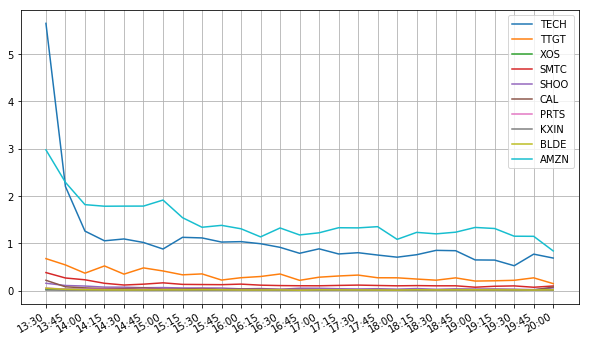

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def plot_15min_data(data_15min: List[pd.DataFrame], on_col: str):
    fig, ax = plt.subplots(figsize=(10, 6))

    for idx, data in enumerate(data_15min):
        ax.plot(data.index, data[on_col], label=data['ticker'].iloc[0])

        labels = [str(x)[-8:-3] for x in data.index]
        plt.xticks(ticks=all_15min_data[0].index, labels=labels)

        ax.xaxis_date()
        fig.autofmt_xdate()

        # myLocator = mticker.IndexLocator(base=4, offset=8)
        # ax.xaxis.set_major_locator(myLocator)
    ax.grid()
    plt.legend()
    plt.show()
plot_15min_data(all_15min_data, 'spread')

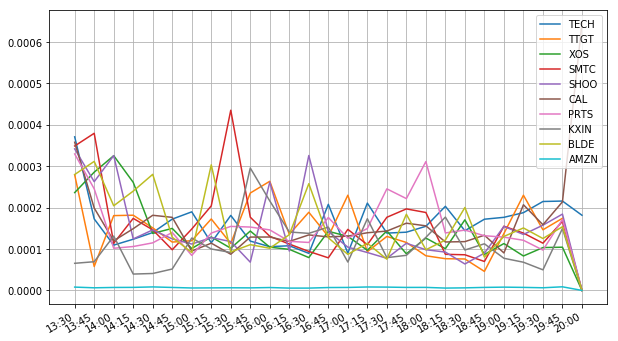

In [9]:
plot_15min_data(all_15min_data, 'vol %')

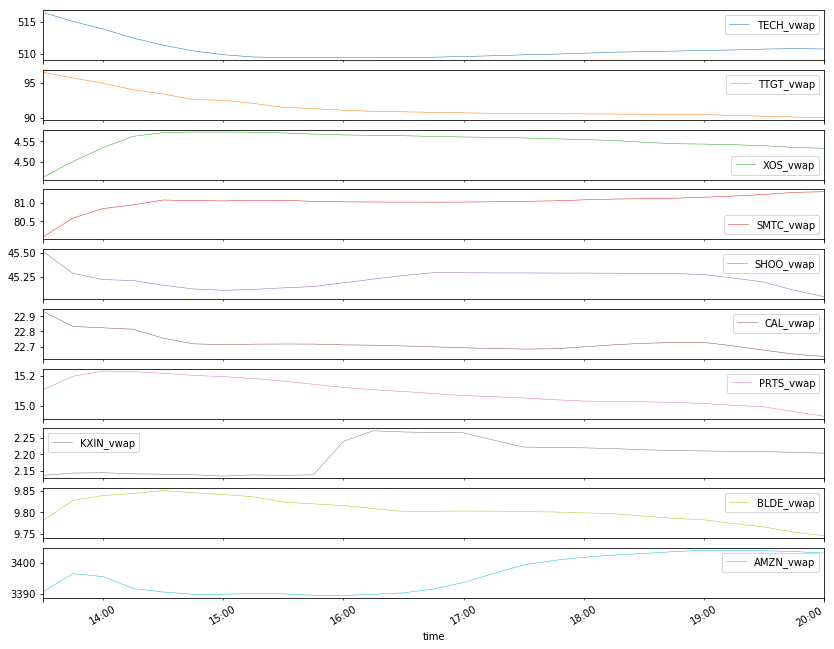

In [10]:
def plot_vwap(pdf):
    dats = pd.DataFrame()
    for data in pdf:
        if 'time' not in dats.columns:
            dats['time'] = data.index            
        ticker = data['ticker'].iloc[0]
        dats[ticker + '_vwap'] = data['vwap'].values
    dats = dats.set_index('time')
#     print(dats.head())
    cols_plot = list(dats.columns)
    axes = dats[cols_plot].plot(linewidth=0.5, figsize=(14, 12), subplots=True)
    for ax in axes:
        ax.set_ylabel('')
plot_vwap(all_15min_data)

In [ ]:
# import seaborn as sns
# import numpy as np
# def plot_vwap_dist(pdf):
#     agg_data = pd.concat(pdf).reset_index()
#     agg_data = agg_data[['time', 'ticker', 'vwap']]
#     sns.catplot(x=agg_data.ticker, y=agg_data.vwap,  kind='box')
#
# plot_vwap_dist(all_15min_data, 'vwap')
# import plotly.graph_objects as go
#
# fig = go.Figure()
# fig.add_trace(go.Histogram(x=log_returns.COST, name='COST'))
# fig.add_trace(go.Histogram(x=log_returns.NIO, name='NIO'))
# fig.add_trace(go.Histogram(x=log_returns.AMD, name='AMD'))
#
# fig.update_xaxes(range=[log_min, log_max])
# fig.update_layout(autosize=True, height=450, barmode='overlay', title='Log returns: COST,NIO,AMD')
# fig.update_traces(opacity=0.5)
# fig.show()

## Question 2

### prepare normalized mid price

In [174]:
from copy import deepcopy

all_data_2 = deepcopy(all_data)
print([(df.ticker.iloc[0], df.shape) for df in all_data_2])

[('BLDE', (6279, 25)), ('TECH', (6078, 25)), ('SMTC', (6160, 25)), ('AMZN', (140133, 25)), ('SHOO', (6132, 25)), ('PRTS', (6146, 25)), ('CAL', (6159, 25)), ('KXIN', (6116, 25)), ('TTGT', (6161, 25)), ('XOS', (6195, 25))]


#### create normalize testing

In [163]:
# data1: pd.DataFrame = all_data_2[0].copy()
# data1[['time', 'ticker', 'bid_price', 'ask_price', 'spread', 'volume','vol %']].head()

In [164]:
# # data1 = data1.set_index('time')
# data1['mid_price'] = (data1['bid_price'] + data1['ask_price'])/2
# data1['mid_price'].head(15)

In [165]:
# %%time

import bisect

# O(N*log(N)) N -> rows

def get_mid_prc_norm_ret_df(pdf):
    dt, midprcs = pdf['time'], pdf['mid_price']
#     print(len(dt) , len(midprcs))
    mid_ret = []

    for idx, (currt, p) in enumerate(zip(dt, midprcs)):
        try:
            curr_p10 = currt + pd.Timedelta('10s')
            nxtidx = bisect.bisect_left(dt, curr_p10)
            if nxtidx >len(dt) - 1:
                nxtidx = len(dt)-1
            nxttime = dt[nxtidx]
#             print(currt, '|',curr_p10, '|',nxttime.floor('s'))
            if curr_p10 >= nxttime.floor('s'):
                midprc_p10 =midprcs[nxtidx]
            else:
                midprc_p10 =midprcs[nxtidx-1]
                nxttime = dt[nxtidx-1]

            midret = (midprc_p10/p)-1
            def format_time(t):
                return t.strftime('%H:%M:%S:%f')[:-3]
            mid_ret.append((midret, format_time(currt) ,p, format_time(curr_p10), format_time(nxttime), midprc_p10))
        except Exception as e:
            print(idx, e)
            continue
        
    return pd.DataFrame(mid_ret, columns=['mid_ret', 'time', 'mid_price', 'time+10+suppose','time+10+choose','mid_price_at_10'])
# midretdf = get_mid_prc_norm_ret_df(data1)

In [166]:
# midretdf.head()

In [12]:
%%time

import bisect

# O(N*log(N)) N -> rows

def get_mid_prc_ret(pdf: pd.DataFrame):
#     pdf['denom'] = pdf['ask_price'] - pdf['bid_price']
    dt, midprcs = pdf['time'], pdf['mid_price']
    
    mid_ret = []

    for idx, (currt, p) in enumerate(zip(dt, midprcs)):
        try:
            curr_p10 = currt + pd.Timedelta('10s')
            nxtidx = bisect.bisect_left(dt, curr_p10)
            if nxtidx >len(dt) - 1:
                nxtidx = len(dt)-1
            nxttime = dt[nxtidx]
            if curr_p10 >= nxttime.floor('s'):
                midprc_p10 =midprcs[nxtidx]
            else:
                midprc_p10 =midprcs[nxtidx-1]
                nxttime = dt[nxtidx-1]

            midret = (midprc_p10/p)-1
            mid_ret.append((midret, nxttime))
        except Exception as e:
            print('err',idx, e)
    return mid_ret
mid_normret = get_mid_prc_ret(data1)

CPU times: user 717 ms, sys: 8.45 ms, total: 726 ms
Wall time: 726 ms


In [106]:
# %%time
# nums = []
# q = Queue()
# table = {}
# prev = 0
# for num in nums:
#     q.put(num)
#     while num > q.get():
#         table[q.get()] = prev
#         q.pop()
#     prev = num
# O(N)

    


#### calculating normalized mid price return
### complete testing, mapping all data

In [175]:
def create_respond_var(pdf:pd.DataFrame):
    respond = pd.DataFrame()
    respond['time'] = pdf['time']
    respond['mid_price'] = (pdf['bid_price'] + pdf['ask_price'])/2
    respond['denom'] = pdf['ask_price'] - pdf['bid_price']
    mask = respond['denom'] > 0
    respond = respond[mask]
    respond = respond.reset_index(drop=True)
    return respond

respond_data = [create_respond_var(df) for df in all_data_2]


In [176]:
from collections import deque
from typing import Deque
def get_t_p_10_midprc(pdf: pd.DataFrame):
    time, midprcs = pdf['time'], pdf['mid_price']
    qt: Deque = deque([])
    time_10 = [0]*len(time)
    price_10 = [0]*len(midprcs)
    prevt = time[0]
    prevp = midprcs[0]
    
    for idx, currt in enumerate(time):
        try:
            qt.append(idx)
            ## [1.1, 1.12, 1.14, 2.21]
            while qt and currt > (time[qt[0]] + pd.Timedelta('10s')):
                
                time_10[qt[0]] = prevt
                price_10[qt[0]] = prevp
                qt.popleft()
            prevt = currt
            prevp = midprcs[idx]
        except Exception as e:
            print('err',idx, e)
        
    while qt:
        time_10[qt[0]] = prevt
        price_10[qt[0]] = prevp
        qt.popleft()

    # print(len(qt))
    # return pd.DataFrame({
    #     'time':time, 
    #     'midprcs':midprcs,
    #     'time_10':time_10, 
    #     'price_10':price_10})
    return time_10, price_10

In [177]:
# %%time
def create_normalized_ret(pdf:pd.DataFrame):
    timep10, prcp10 = get_t_p_10_midprc(pdf)
    pdf['timep10'] = timep10
    pdf['prcp10'] = prcp10
    pdf['mid_prc_ret'] = pdf['mid_price']/pdf['prcp10'] -  1
    pdf['mid_prc_norm_ret'] = pdf['mid_prc_ret']/pdf['denom']
    pdf.drop(columns=['timep10','prcp10','mid_prc_ret','denom'], inplace=True)
    return pdf
    
respond_data = [create_normalized_ret(df) for df in respond_data]

In [178]:
for d in respond_data:
    print(d.head())

                     time  mid_price  mid_prc_norm_ret
0 2021-10-27 09:30:00.380      9.865          0.011046
1 2021-10-27 09:30:00.481      9.860          0.009239
2 2021-10-27 09:30:00.527      9.860          0.009239
3 2021-10-27 09:30:00.554      9.860          0.009239
4 2021-10-27 09:30:00.555      9.860          0.009239
                     time  mid_price  mid_prc_norm_ret
0 2021-10-27 09:30:01.287    514.045         -0.000174
1 2021-10-27 09:30:01.368    514.045         -0.000174
2 2021-10-27 09:30:01.412    514.045         -0.000174
3 2021-10-27 09:30:02.457    516.680          0.000092
4 2021-10-27 09:30:02.457    516.680          0.000092
                     time  mid_price  mid_prc_norm_ret
0 2021-10-27 09:30:02.200      80.99               0.0
1 2021-10-27 09:30:02.201      80.99               0.0
2 2021-10-27 09:30:02.201      80.99               0.0
3 2021-10-27 09:30:02.201      80.99               0.0
4 2021-10-27 09:30:02.202      80.99               0.0
          

### prepare predictors

In [179]:
# all_data_cln2 = deepcopy(all_data_cln)
# len(all_data_cln2)

In [181]:
all_data_2[0].head()

,timestamp,ticker,bid_price,bid_size,bid_exchange,ask_price,ask_size,ask_exchange,trade_price,trade_size,...,nbb_no_of_exchange,nbo_agg_size,nbo_no_of_exchange,is_odd_lot,is_hidden_order,is_mid_order,is_buy_order,is_sell_order,is_trade_through,time
0,1635341400380,BLDE,9.75,1100,XNAS,9.98,100,XNAS,9.77,10,...,1,100,1,1,1,0,0,1,0,2021-10-27 09:30:00.380
1,1635341400481,BLDE,9.75,1100,XNAS,9.97,1000,IEXG,9.77,717,...,1,1000,1,0,1,0,0,1,0,2021-10-27 09:30:00.481
2,1635341400527,BLDE,9.75,1100,XNAS,9.97,1000,IEXG,9.77,82,...,1,1000,1,1,1,0,0,1,0,2021-10-27 09:30:00.527
3,1635341400554,BLDE,9.75,1100,XNAS,9.97,1000,IEXG,9.86,100,...,1,1000,1,0,1,1,0,0,0,2021-10-27 09:30:00.554
4,1635341400555,BLDE,9.75,1100,XNAS,9.97,1000,IEXG,9.86,100,...,1,1000,1,0,1,1,0,0,0,2021-10-27 09:30:00.555


In [138]:
def create_predictors(pdf:pd.DataFrame):
    predictors = pd.DataFrame(index=pdf.index)
    predictors['time'] = pdf['time']
    predictors['bid_offer_imbal'] = (pdf['nbb_agg_size'] - pdf['nbo_agg_size'])/(pdf['nbb_agg_size'] + pdf['nbo_agg_size'])
    predictors['trade_sign'] = np.where(pdf['trade_price'] > pdf['mid_price'], 1, -1)
    predictors['trade_sz_imbal'] = predictors['trade_sign']*pdf['trade_size']
    predictors['trade_sz_imbal_10s'] = predictors.set_index('time')['trade_sz_imbal'].rolling('10s').sum().values
    return predictors
# predictor1 = create_predictors(data1)

In [139]:
predictors = [create_predictors(data) for data in all_data_2]

In [140]:
predictors[0].head()

,time,bid_offer_imbal,trade_sign,trade_sz_imbal,trade_sz_imbal_10s
0,2021-10-27 09:30:00.380,0.833333,-1,-10,-10.0
1,2021-10-27 09:30:00.481,0.047619,-1,-717,-727.0
2,2021-10-27 09:30:00.527,0.047619,-1,-82,-809.0
3,2021-10-27 09:30:00.554,0.047619,-1,-100,-909.0
4,2021-10-27 09:30:00.555,0.047619,-1,-100,-1009.0


Running models

In [142]:
import pandas as pd
import numpy as np

from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web

# from linearmodels.asset_pricing import LinearFactorModel

import matplotlib.pyplot as plt
import seaborn as sns